Notebook 4: Revised moel after learnings from the second EDA

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from plotnine import *
import itertools
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn import tree
%matplotlib inline

df = pd.read_csv('sac_animals.csv', parse_dates=True)
df = df[df['outcome_type'].isin(['ADOPTION' ,'FOSTER', 'RTO', 'EUTH', 'TRANSFER', 'RTF', 'DIED', 'EUTH VET'])]

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Create intake month variable

In [3]:
df['intake_date'] = pd.to_datetime(df['intake_date'])
df['intake_month'] = df.intake_date.dt.month

Grab features, spit data, encode and scale data

In [4]:
df['outcome_type_clean'] = df['outcome_type']
df.loc[df['outcome_type_clean'].isin(['DIED', 'EUTH', 'EUTH VET']), 'outcome_type_clean'] = 'DIED'

c_data = df[['animal_type', 'animal_sex_clean', 'animal_intake_status', 'name_unknown', 'has_activity_number',
            'animal_age_in_days', 'outcome_type_clean', 'intake_type', 'color_clean', 'intake_times', 'days_spent', 'intake_month']]

c_data = c_data.dropna()
y = c_data['outcome_type_clean']
x = c_data.drop('outcome_type_clean', axis=1)
x = x.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=99, stratify=y)
target_names = ['ADOPTION', 'DIED', 'FOSTER', 'RTF', 'RTO', 'TRANSFER']

In [6]:
scaler = StandardScaler()
x_train[['animal_age_in_days', 'days_spent']] = scaler.fit_transform(x_train[['animal_age_in_days', 'days_spent']])
x_test[['animal_age_in_days', 'days_spent']] = scaler.transform(x_test[['animal_age_in_days', 'days_spent']])

<ipython-input-6-40b4b784e505>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/justingoss/Desktop/sac_animals/sac_animals/lib/python3.9/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-6-40b4b784e505>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Set grid search

In [7]:
criterion = ['gini', 'entropy']
components = [175, 200, 225]
estimators = [100, 250, 500]
k = [10, 15, 20]
cv = StratifiedKFold(3)

Fit cross validated, tuned random forest model

In [8]:
rf = RandomForestClassifier(class_weight='balanced_subsample', bootstrap=True, oob_score=True)

rf_gridcv = GridSearchCV(estimator=rf, param_grid=dict(n_estimators=estimators, 
                                                     criterion=criterion), 
                         scoring='accuracy', cv=cv, return_train_score=True)

rf_gridcv.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              oob_score=True),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [100, 250, 500]},
             return_train_score=True, scoring='accuracy')

In [9]:
results = pd.DataFrame(rf_gridcv.cv_results_)
results.sort_values(by='rank_test_score', ascending=True, inplace=True)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
1,3.217579,0.009126,0.273061,0.002048,gini,250,"{'criterion': 'gini', 'n_estimators': 250}",0.791593,0.777498,0.789301,0.786131,0.006176,1,0.980618,0.981373,0.980871,0.980954,0.000314
2,6.531744,0.018273,0.553563,0.019529,gini,500,"{'criterion': 'gini', 'n_estimators': 500}",0.788195,0.778631,0.789301,0.785376,0.004791,2,0.980744,0.981499,0.980934,0.981059,0.000321
5,7.184374,0.017933,0.540613,0.012888,entropy,500,"{'criterion': 'entropy', 'n_estimators': 500}",0.787944,0.779386,0.788798,0.785376,0.004250,3,0.980744,0.981499,0.980997,0.981080,0.000314
3,1.448513,0.006502,0.113576,0.003650,entropy,100,"{'criterion': 'entropy', 'n_estimators': 100}",0.790964,0.775107,0.789553,0.785208,0.007166,4,0.980366,0.981499,0.980871,0.980912,0.000463
4,3.604280,0.059637,0.274213,0.003920,entropy,250,"{'criterion': 'entropy', 'n_estimators': 250}",0.787189,0.777498,0.789050,0.784579,0.005064,5,0.980807,0.981373,0.980934,0.981038,0.000243


Model accuracy improves by about 4 percentage points, not bad

In [10]:
rf_grid_pred = rf_gridcv.predict(x_test)
print(classification_report(y_test, rf_grid_pred, target_names=target_names))

              precision    recall  f1-score   support

    ADOPTION       0.82      0.88      0.85      4575
        DIED       0.68      0.64      0.66      1231
      FOSTER       0.82      0.82      0.82      3424
         RTF       0.72      0.72      0.72       319
         RTO       0.79      0.74      0.76      1593
    TRANSFER       0.57      0.43      0.49       599

    accuracy                           0.79     11741
   macro avg       0.74      0.71      0.72     11741
weighted avg       0.79      0.79      0.79     11741



Normalized confusion matrix


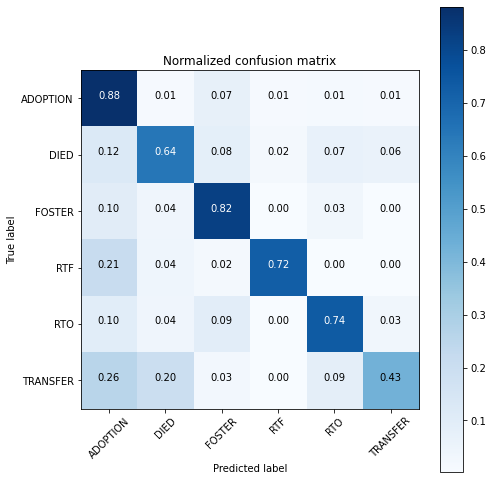

In [11]:
plt.figure(figsize=(7, 7))
rf_cnf_mat = confusion_matrix(y_test, rf_grid_pred)
plot_confusion_matrix(rf_cnf_mat, classes=target_names, normalize=True, title='Normalized confusion matrix')

Still have a hard time predicting transfers, have trouble distinguishing them from adoptions and deaths. Deaths and euthenasias are just challenging to predict period.